importation des bibliothèques requises

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.DenseNet121 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score, accuracy_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 224
NUM_CLASSES = 5

Using TensorFlow backend.


lire les dataframe pandas pour les relier les labels aux images

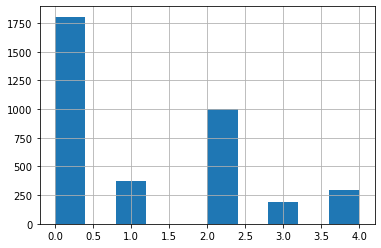

In [2]:
df_train = pd.read_csv('/datasets/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('/datasets/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=8)
y.hist()


deviser le data-set en partie train partie test 

In [3]:
y = to_categorical(y, num_classes=NUM_CLASSES)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(3112,)
(3112, 5)
(550,)
(550, 5)


creation de la fonction de preprocessing en utilisant la bibliothèque imgaug
(flou,contrast,retourner,couper ...)

In [4]:
#src imgaug : https://github.com/aleju/imgaug
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Flipud(0.5)
],random_order=True)


creation de la class My_Generator la class qui s'occcupe de creer est les generator et aussi d'appliquer le preprocessing sur la partie train 

In [5]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=False,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('/datasets/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('/datasets/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

importer les bibliothèques requise pour le model et son entrainement

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

creation de la fonction de creation du model  

In [7]:
#source weights : https://github.com/titu1994/DenseNet/releases/download/v3.0/DenseNet-BC-121-32-no-top.h5
function = "softmax"
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    base_model = DenseNet121(include_top=False,
    weights='DenseNet-BC-121-32-no-top.h5',
    input_tensor=input_tensor)
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation=function, name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

creation de :
    - modelchekpoint : pour savgarder les poids du model a chaque dimunition du val_loss.
    - reduceLROnPlat : pour reduire le taux d'apprentissage si le val_loss cesse de se         reduire afin d'eviter le surajustement
    - CSVLogger : pour sauvgareder les metrique pendant l'entainement 
    - earlystoping : pour stoper l'entainement automatiqument si le val_loss ne se reduit       pendant longtemps.
et creer le model

In [8]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 30; batch_size = 32
checkpoint = ModelCheckpoint('Densenet121.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='training_logdn.csv',
                       separator=',',
                       append=True)
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]
train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

creation la class  QWKEvaluation qui s'occupe de l'evaluation avec Quadratic Weighted Kappa score ainsi de sauvgarder le model a chaque amelioration du score .

In [9]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=True,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
                # return np.sum(y.astype(int), axis=1) - 1
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')

            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('save checkpoint: ', score)
                self.model.save('Densenet121_bestqwk.h5')

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

rechaufer un peu le model afin de regler un peu les poids pour un meileur demarage a l'entrainement

In [10]:

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
 
    optimizer=Adam(1e-3))

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk])

Epoch 1/2
18/18 [==============================] - 43s 2s/step

 epoch: 1 - QWK_score: 0.018221 

save checkpoint:  0.0182212386398104
Epoch 2/2
18/18 [==============================] - 42s 2s/step

 epoch: 2 - QWK_score: 0.018221 

save checkpoint:  0.0182212386398104


ajout des parametres creer precedement au model, choix des metrique (accuracy, precission, recall) et compiler le model et l'entrainer

In [11]:

for layer in model.layers:
    layer.trainable = True
optimizer=Adam(0.00005)
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list
)

Epoch 1/30
98/98 [==============================] - 295s 3s/step - loss: 0.7888 - accuracy: 0.7108 - precision: 0.7875 - recall: 0.5829 - val_loss: 0.6830 - val_accuracy: 0.5418 - val_precision: 0.7751 - val_recall: 0.6039

Epoch 00001: val_loss improved from inf to 0.68303, saving model to Densenet121.h5
18/18 [==============================] - 42s 2s/step

 epoch: 1 - QWK_score: 0.281205 

save checkpoint:  0.28120468514119346
Epoch 2/30
98/98 [==============================] - 228s 2s/step - loss: 0.6437 - accuracy: 0.7612 - precision: 0.7822 - recall: 0.6150 - val_loss: 0.4666 - val_accuracy: 0.6255 - val_precision: 0.7894 - val_recall: 0.6256

Epoch 00002: val_loss improved from 0.68303 to 0.46660, saving model to Densenet121.h5
18/18 [==============================] - 42s 2s/step

 epoch: 2 - QWK_score: 0.511312 

save checkpoint:  0.5113124944680099
Epoch 3/30
98/98 [==============================] - 226s 2s/step - loss: 0.5921 - accuracy: 0.7738 - precision: 0.7932 - recall: 0.

KeyboardInterrupt: 

Visualsation des avancements du metriques pendant l'entrainement : metrique(epoque)

In [32]:
df = pd.read_csv("training_logdn.csv")
df.head()

epoch  accuracy      loss  precision    recall  val_accuracy  val_loss  \
0      0  0.717224  0.778990   0.776550  0.637786      0.685455  0.396866   
1      1  0.757069  0.639505   0.796252  0.646436      0.694545  0.267300   
2      2  0.772815  0.593931   0.802270  0.663131      0.807273  0.134707   
3      0  0.710797  0.785475   0.787457  0.582864      0.541818  0.683033   
4      1  0.761247  0.634537   0.782207  0.614975      0.625455  0.466604   

   val_precision  val_recall  
0       0.785220    0.634849  
1       0.799228    0.655667  
2       0.809788    0.672185  
3       0.775098    0.603886  
4       0.789389    0.625631

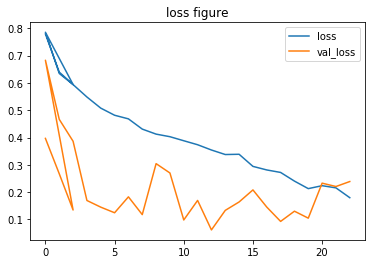

In [35]:
df = pd.read_csv("training_logdn.csv")
ep=df["epoch"]
los=df['loss']
vlos=df['val_loss']
import matplotlib.pyplot as plt
plt.figure()
plt.title('loss figure')
plt.plot(ep,los,label='loss')
plt.plot(ep,vlos,label='val_loss')
plt.legend()
plt.show()

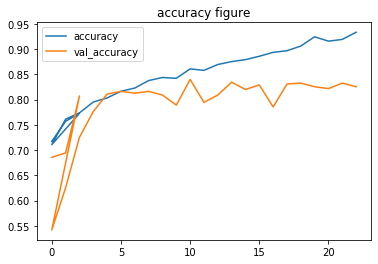

In [37]:
acc=df['accuracy']
vacc=df['val_accuracy']
import matplotlib.pyplot as plt
plt.figure()
plt.title('accuracy figure')
plt.plot(ep,acc,label='accuracy')
plt.plot(ep,vacc,label='val_accuracy')
plt.legend()
plt.show()

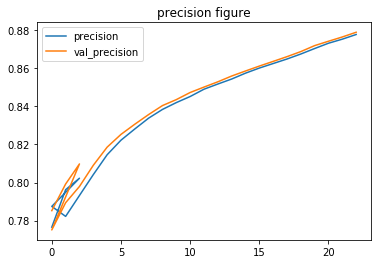

In [38]:
prc=df['precision']
vprc=df['val_precision']
import matplotlib.pyplot as plt
plt.figure()
plt.title('precision figure')
plt.plot(ep,prc,label='precision')
plt.plot(ep,vprc,label='val_precision')
plt.legend()
plt.show()

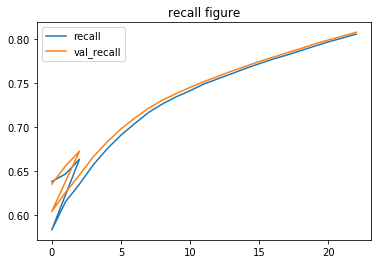

In [39]:
rc=df['recall']
vrc=df['val_recall']
import matplotlib.pyplot as plt
plt.figure()
plt.title('recall figure')
plt.plot(ep,rc,label='recall')
plt.plot(ep,vrc,label='val_recall')
plt.legend()
plt.show()

In [22]:
model.save("aptosDensenet121.h5")
submit = pd.read_csv('/datasets/aptos2019-blindness-detection/sample_submission.csv')
# model.load_weights('Densenet121.h5')
model.load_weights('Densenet121_bestqwk.h5')
predicted = []

In [23]:
model.save('densnet.h5')